When training autoencoder on CIFAR10 data, if using batch size is 100 results in "out of memory error", so I used a smaller size--25 as batch size.
- Training autoencoder
 - The model structure is adapted from the tutorial, and because it already shows good denoising performance so I didn't change it
 - I used Adam as optimizer
 - Adjusting learning rate of Adam among: 0.001(default), 0.01, 0.0005: The training loss of the last epoch are 
 0.00219, 0.00352, 0.00252, so I save the resulting model of learning_rate=0.001 as "deno_autoencoder_CIFAR10_final.pkl"


- Concat FC to saved encoder and train it for CIFAR10 classification task
 - I use 5 layer FC, each hidden layer contains 1000 neurons, in each layer batch normalization is applied (BatchNorm1d)
 - For optimizer, I tried: (epoch=15, batch_size=25)
   - Adam with lr=0.001(default) (best epoch average test accuracy: 54.81%)
   - Adam with lr=0.002 (best epoch average test accuracy: 58.84%)
   - Adam with lr=0.005 (best epoch average test accuracy: 48.32%)
   - Adadelta with lr=1.0(default) (best epoch average test accuracy: 52.29%)
 - So I saved the parameters of the model trained with Adam(lr=0.002) as "deno_autoencoder_fc_best"


- For the soccer dataset (For more details please see 5_Autoencoder_soccer_images.ipynb)
 - I used additive Gaussian noise to make the original image noisy
 - If I set the number of model parameters proportional to that used for CIFAR (for example use 224 instead of 32 filters in the first layer of encoder), then the model is too big and I run into "out of memory" error
 - So I tried the 3 different smaller sized encoders (small, middle, big, and corresponding decoders. Details in 5_Autoencoder_soccer_images.ipynb), and it turns out if I use the Adam and the same default learning rate 0.001, then the training loss of these models are relatively similar to each other (all 3 seem to converge, and lowest epoch average test MSEloss: 1.154 for middle model, 1.146 for small model, 1.166 for big model), although it takes much longer to train the big model
 - So I saved the trained small model as /model/deno_autoencoder_soccer_small.pkl, and use the encoder part to concat with FC and train for classification of soccer/no_soccer
 - But when I try to train the model for classification, it always results in "out of memory" error, and I couldn't find out the reason, so I couldn't proceed
 - Compared to well reconstructed images of CIFAR10, the reconstructed image for the soccer images resembles much less to the orginal image, but rather simple and abstract with details lost:
 - Example: <img src="orginal.png"><img src="input_noisy.png"><img src="reconstructed_output.png">



In [20]:
# Simple Convolutional Autoencoder
# Code adapted from GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import time
import numpy as np
CUDA = torch.cuda.is_available()

%matplotlib inline

# Set Hyperparameters and load data

In [45]:
epoch = 10
batch_size = 25 # 100 will result in "out of memory" error
learning_rate = 0.001 # for training autoencoder

num_neuron_layer=1000 # number of neurons in each fully connected layer
learning_rate_2 = 0.002 # for training FC
momentum=0.9 # for training FC

# Download Data

cifar_train = dset.CIFAR10("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test  = dset.CIFAR10("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=cifar_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test,batch_size=batch_size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Train denoising autoencoder
### Encoder 

In [22]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 32 x 32
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),  # batch x 128 x 8 x 8
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 8 x 8
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    


### Decoder 

In [23]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# The kernel_size, stride, padding here are the values used in convolution
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# Above equation is the inverse process of the one in convolution (except the output_padding part): 
# output_height=(input_height + 2∗padding - kernel_size) / stride + 1 (should round down to an integer)

# batch x 512 -> batch x 1 x 28 x 28


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), # stride=2 because of pooling in convolution
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1), # no output padding  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,8,8)
        out = self.layer1(out)
        out = self.layer2(out)
        return out



In [24]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()

### Self written Adam optimizer

In [25]:
class AdamOptimizer():
    
    def __init__(self,params,lr=0.001,betas=(0.9, 0.999), eps=1e-08, cuda=True): # params is the groups of parameters of a NN model
        self.params=list(params) #params should be generator
        if cuda==True:
            self.first_moment=[Variable(torch.zeros(param_group.data.size()),requires_grad=False).cuda() for param_group in self.params] # a list of Variables
            self.second_moment=[Variable(torch.zeros(param_group.data.size()),requires_grad=False).cuda() for param_group in self.params]
        else:
            self.first_moment=[Variable(torch.zeros(param_group.data.size()),requires_grad=False) for param_group in self.params] # a list of Variables
            self.second_moment=[Variable(torch.zeros(param_group.data.size()),requires_grad=False) for param_group in self.params]
        # Make these also Variable because we can only do arithmetic computation between Variables, but not Variable with Tensor
        self.timepoint=0
        self.lr=lr
        self.beta1=betas[0]
        self.beta2=betas[1]
        self.eps=eps
    
    def zero_grad(self):
        for param_group in self.params:
            if param_group.grad is None: # if no gradient of the parameters has been calculated yet
                return
            param_group.grad.data.zero_() # set all the gradients of the parameters to zero
    
    def step(self):
        self.timepoint+=1
        param_group_idx=0 #index of the parameter groups
        for param_group in self.params:
            self.first_moment[param_group_idx] = self.beta1 * self.first_moment[param_group_idx] + (1 - self.beta1) * param_group.grad
            self.second_moment[param_group_idx] = self.beta2 * self.second_moment[param_group_idx] + (1 - self.beta2) * param_group.grad * param_group.grad
            first_unbiased = self.first_moment[param_group_idx] / (1 - self.beta1**self.timepoint) # calculate unbiased first moment
            second_unbiased = self.second_moment[param_group_idx] / (1 - self.beta2**self.timepoint) # calculate unbiased second moment
            param_group.data.add_(-(self.lr * first_unbiased / (second_unbiased**0.5 + self.eps)).data) # update parameters
            param_group_idx+=1
            

### Noise

In [26]:
noise = torch.rand(batch_size,3,32,32)

### Loss function and optimizer

In [27]:
# Loss function: use Mean Squared Error
# del optimizer
parameters = list(encoder.parameters())+ list(decoder.parameters()) # concat parameters
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
# optimizer = AdamOptimizer(parameters,lr=learning_rate,cuda=CUDA) # using self written Adam
loss_func = nn.MSELoss().cuda()


### Check output dimensions of autoencoder

In [28]:
# (25, 3, 32, 32)
for image,label in train_loader:
    print(image.numpy().shape)
    image = Variable(image).cuda()
    
    output = encoder(image)
    print(output.cpu().data[0].numpy().shape)
    output = decoder(output)
    print(output.size())
    break

(25, 3, 32, 32)
(16384,)
torch.Size([25, 3, 32, 32])


In [29]:
# del encoder
# del decoder
# # Free memory

### Train autoencoder

In [30]:
since = time.time()
loss_vec_train=[] # average training loss of each epoch
loss_vec_test=[] # average test loss of each epoch


for i in range(epoch):
    encoder.train() # set the models to train mode
    decoder.train()
    print("Epoch {}:".format(i+1))
    num_iter=0 # index of iteration in each epoch
    epoch_loss=0
    for image,label in train_loader:
        num_iter+=1
        image_n = torch.mul(image+0.25, 0.1 * noise) # add noise to original image
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.data[0]
        if num_iter%500==0:
            print("MSE Loss: {:.4f} * 1e-03  [{}/{} ({:.0f}%)]"
                  .format(loss.data[0]*1000,num_iter*batch_size,len(train_loader)*batch_size,num_iter/len(train_loader)*100))
            
    # record loss change
    epoch_loss/=len(train_loader)
    loss_vec_train.append(epoch_loss) # Add the average loss of this epoch
    time_elapsed = time.time() - since
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    
    # test on test dataset
    encoder.eval() # set the models to evaluation mode
    decoder.eval()
    test_loss=0
    for image,label in test_loader:
        image_n = torch.mul(image+0.25, 0.1 * noise) # add noise to original image
        image = Variable(image, volatile=True).cuda()  # volatile=True is more efficient when you won’t call .backward()
        image_n = Variable(image_n, volatile=True).cuda()
        #label = Variable(label.float()).cuda()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        test_loss+=loss.data[0]
    
    print("Average test MSE Loss: {:.4f} * 1e-03".format(test_loss/len(test_loader)*1000))   
    loss_vec_test.append(test_loss/len(test_loader))
    time_elapsed = time.time() - since # Add the average test loss of this epoch
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
          
# record time                
print("Final MSE Loss: {}".format(loss.data[0]))


Epoch 1:
MSE Loss: 9.3429 * 1e-03  [12500/50000 (25%)]
MSE Loss: 6.6287 * 1e-03  [25000/50000 (50%)]
MSE Loss: 7.1865 * 1e-03  [37500/50000 (75%)]
MSE Loss: 5.3503 * 1e-03  [50000/50000 (100%)]
Time elapsed: 2m 25s

Average test MSE Loss: 4.9718 * 1e-03
Time elapsed: 2m 35s

Epoch 2:
MSE Loss: 5.7882 * 1e-03  [12500/50000 (25%)]
MSE Loss: 4.0427 * 1e-03  [25000/50000 (50%)]
MSE Loss: 3.2105 * 1e-03  [37500/50000 (75%)]
MSE Loss: 8.6570 * 1e-03  [50000/50000 (100%)]
Time elapsed: 5m 4s

Average test MSE Loss: 4.1794 * 1e-03
Time elapsed: 5m 14s

Epoch 3:
MSE Loss: 3.1217 * 1e-03  [12500/50000 (25%)]
MSE Loss: 4.5545 * 1e-03  [25000/50000 (50%)]
MSE Loss: 2.5123 * 1e-03  [37500/50000 (75%)]
MSE Loss: 2.4638 * 1e-03  [50000/50000 (100%)]
Time elapsed: 7m 44s

Average test MSE Loss: 3.9433 * 1e-03
Time elapsed: 7m 55s

Epoch 4:
MSE Loss: 3.2391 * 1e-03  [12500/50000 (25%)]
MSE Loss: 2.5337 * 1e-03  [25000/50000 (50%)]
MSE Loss: 2.3057 * 1e-03  [37500/50000 (75%)]
MSE Loss: 2.0245 * 1e-03  

### Plot training and test loss

[0.010364478191593663, 0.004966356046847068, 0.003809192085871473, 0.003282448042940814, 0.002914880636089947, 0.0027087100017815827, 0.002523546628886834, 0.002433675814769231, 0.0022964707099599763, 0.0021905308330897244]


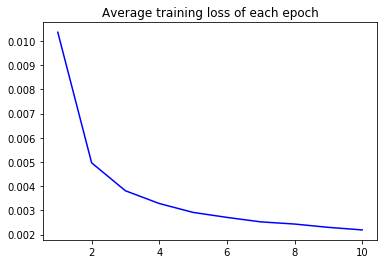

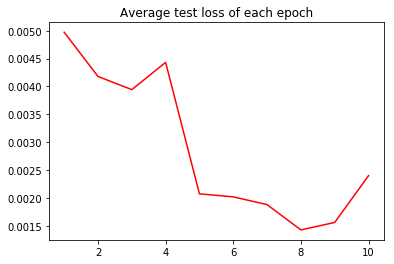

In [32]:
print(loss_vec_train)
       
plt.plot(np.arange(1,epoch+1),loss_vec_train, 'b') #visualize loss change
plt.title('Average training loss of each epoch')
plt.show()

plt.plot(np.arange(1,epoch+1),loss_vec_test, 'r') #visualize loss change
plt.title('Average test loss of each epoch')
plt.show()

### Save model

In [41]:
if not os.path.exists('./model'):
    os.mkdir('./model')
torch.save([encoder,decoder],'./model/deno_autoencoder_CIFAR10_final.pkl')

/home/local/stud/zhaoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/local/stud/zhaoy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Check denoised output image

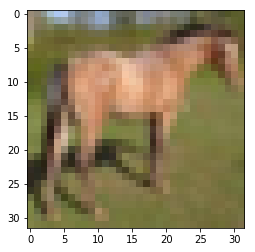

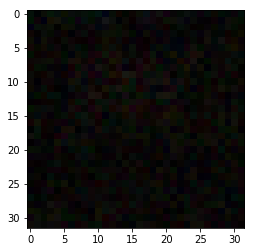

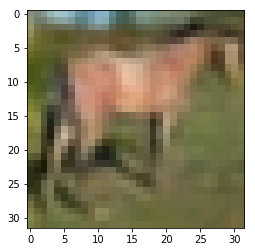

7


In [40]:
img = image[0].cpu()
input_img = image_n[0].cpu()
output_img = output[0].cpu()

origin = img.data.numpy()
inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.imshow(origin.transpose((1,2,0)))
plt.show()

plt.imshow(inp.transpose((1,2,0)))
plt.show()

plt.imshow(out.transpose((1,2,0)))
plt.show()

print(label[0])

# Use the latent space of trained encoder to do classification 
### Loading stored encoder, and fix its parameters

In [ ]:
# del encoder
# del decoder

In [49]:
# Load model
# try loading stored model
try:
    encoder, decoder = torch.load('./model/deno_autoencoder_CIFAR10_final.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

del decoder # decoder will not be used

for param in encoder.parameters():
    param.requires_grad = False # do not change the weights in the encoder layers
encoder.cuda()



--------model restored--------



Encoder(
  (layer1): Sequential(
    (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (6): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (9): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Re

### Fully connected layer to be concatenated to encoder

In [44]:
class FC(nn.Module):
    def __init__(self):
        super(FC,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Linear(256*8*8,num_neuron_layer), # hidden layer 1
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer), # should I add this layer? Yes, result in faster learning and has regularization function
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 2
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 3
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,num_neuron_layer), # hidden layer 4
                        nn.ReLU(),
                        nn.BatchNorm1d(num_neuron_layer),
                        nn.Linear(num_neuron_layer,10), # hidden layer 5
        )
        
        
    def forward(self,x):
        out = x.view(batch_size,-1)
        out = self.layer1(out)
        return out


### Initialize fully connected layer, classification loss function and optimizer

In [51]:
fc_layers=FC().cuda() # should reinitialize every time when changing the optimizer!!

criterion = nn.CrossEntropyLoss().cuda()
parameters_2 = fc_layers.parameters()

# optimizer_2 = AdamOptimizer(parameters_2,lr=learning_rate_2,cuda=CUDA) # self-written adam optimizer
optimizer_2 = torch.optim.Adam(parameters_2, lr=learning_rate_2)
# optimizer_2 = torch.optim.SGD(parameters_2, lr=learning_rate_2, momentum=momentum)
# optimizer_2 = torch.optim.Adadelta(parameters_2) # Default lr of Adadelta is 1.0

In [52]:
# del parameters_2
# del optimizer_2
# del fc_layers
# # To free memory
# epoch=20

### concatenate encoder and fc and train fc

In [53]:
since = time.time()
acc_vec_train=[] # average training accuracy of each epoch
acc_vec_test=[] # average test accuracy of each epoch
best_acc=0.0

for i in range(epoch):
    encoder.train() # set the models to train mode
    fc_layers.train()
    print("Epoch {}:".format(i+1))
    num_iter=0 # index of iteration in each epoch
    epoch_acc=0 # average accuracy of epoch
    train_acc=0 # training accuracy of this epoch
    for image,label in train_loader:
        num_iter+=1
        image_n = torch.mul(image+0.25, 0.1 * noise) # add noise to original image
        # image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        label = Variable(label).cuda()
        optimizer_2.zero_grad()
        output = encoder(image_n)
        output = fc_layers(output)
        loss = criterion(output,label)
        loss.backward()
        optimizer_2.step()
        
        pred = output.data.max(1)[1] # pred is a vector of indices of row-wise max of output
        correct = pred.eq(label.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size
        train_acc+=accuracy
        
        if num_iter%250==0:
            print("Loss: {:.4f}  [{}/{} ({:.0f}%)]"
                  .format(loss.data[0],num_iter*batch_size,len(train_loader)*batch_size,num_iter/len(train_loader)*100))
    
    print("Average training accuracy: {:.2f}%".format(train_acc/len(train_loader))) 
    acc_vec_train.append(train_acc/len(train_loader))            
    # record loss change
    time_elapsed = time.time() - since
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    
    # test on test dataset
    encoder.eval() # set the models to evaluation mode
    fc_layers.eval()
    test_acc=0 # test acc of this epoch
    for image,label in test_loader:
        image_n = torch.mul(image+0.25, 0.1 * noise) # add noise to original image
        # image = Variable(image, volatile=True).cuda()  # volatile=True is more efficient when you won’t call .backward()
        image_n = Variable(image_n, volatile=True).cuda()
        label = Variable(label).cuda()
        output = encoder(image_n)
        output = fc_layers(output)
        loss = criterion(output,label)
        
        pred = output.data.max(1)[1] # pred is a vector of indices of row-wise max of output
        correct = pred.eq(label.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size
        test_acc+=accuracy
    epoch_test_acc=test_acc/len(test_loader)
    if epoch_test_acc>best_acc: #update the best model
        best_acc = epoch_test_acc
        best_model_wts = fc_layers.state_dict()
    print("Average test accuracy: {:.2f}%".format(epoch_test_acc))   
    acc_vec_test.append(epoch_test_acc)

    time_elapsed = time.time() - since # Add the average test loss of this epoch
    print("Time elapsed: {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
    

Epoch 1:
Loss: 2.0434  [6250/50000 (12%)]
Loss: 1.7264  [12500/50000 (25%)]
Loss: 1.8459  [18750/50000 (38%)]
Loss: 2.1164  [25000/50000 (50%)]
Loss: 1.7653  [31250/50000 (62%)]
Loss: 1.5206  [37500/50000 (75%)]
Loss: 1.4898  [43750/50000 (88%)]
Loss: 1.5223  [50000/50000 (100%)]
Average training accuracy: 39.28%
Time elapsed: 0m 58s

Average test accuracy: 46.62%
Time elapsed: 1m 5s

Epoch 2:
Loss: 1.2554  [6250/50000 (12%)]
Loss: 1.4197  [12500/50000 (25%)]
Loss: 1.2310  [18750/50000 (38%)]
Loss: 1.2733  [25000/50000 (50%)]
Loss: 1.5439  [31250/50000 (62%)]
Loss: 1.2230  [37500/50000 (75%)]
Loss: 1.6055  [43750/50000 (88%)]
Loss: 1.7158  [50000/50000 (100%)]
Average training accuracy: 47.13%
Time elapsed: 2m 4s

Average test accuracy: 49.01%
Time elapsed: 2m 11s

Epoch 3:
Loss: 1.3145  [6250/50000 (12%)]
Loss: 1.2926  [12500/50000 (25%)]
Loss: 1.1892  [18750/50000 (38%)]
Loss: 1.3194  [25000/50000 (50%)]
Loss: 1.3734  [31250/50000 (62%)]
Loss: 1.3741  [37500/50000 (75%)]
Loss: 1.2521

### Plot training and test loss

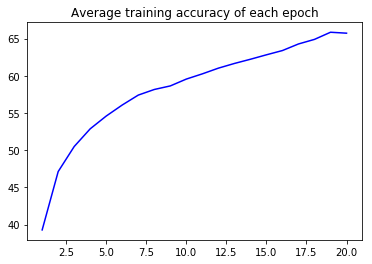

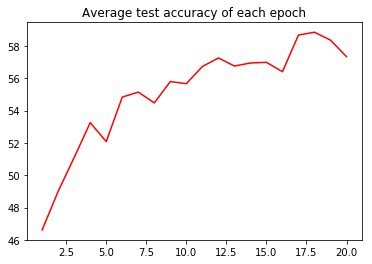

In [54]:
plt.plot(np.arange(1,epoch+1),acc_vec_train, 'b') #visualize loss change
plt.title('Average training accuracy of each epoch')
plt.show()

plt.plot(np.arange(1,epoch+1),acc_vec_test, 'r') #visualize loss change
plt.title('Average test accuracy of each epoch')
plt.show()

### Save the best model parameters

In [56]:
if not os.path.exists('./model'):
    os.mkdir('./model')
torch.save(best_model_wts, "./model/deno_autoencoder_fc_best") # save with name of the corresponding autoencoder + "_fc"